## ETK Filtering

In [9]:
import Simulator
import Observation
import Statistics
import IEWParticleFilter

## Loading simulator 

For Kalman filtering we have to be able to propagate a Gaussian distribution in time and to have access to the linear operators

In [10]:
timestamp = "2021_08_26-12_22_18"

grid, simulator = Simulator.from_file(timestamp)

## Definition of initial distribution 

The inital state is equipped with a Gaussian distribution specified by its mean and covariance. 

In [11]:
statistics = Statistics.Statistics(simulator, N_e=100)

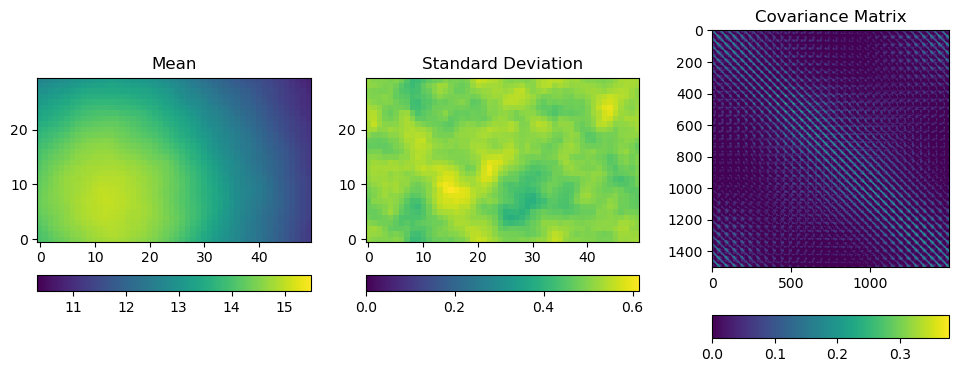

In [12]:
prior_args = Statistics.prior_args_from_file(timestamp)
statistics.set_prior(prior_args)

statistics.plot()

## Loading observations 

Observation positions which are fixed for a setup and values from the truth

In [13]:
obs_timestamp = "2021_08_26-12_22_28"
observation = Observation.from_file(grid, timestamp, obs_timestamp)

Remember to set observation positions and to set/observe values!


## IEWPF filtering

Updating/conditioning the distributions at every observation time

In [14]:
statistics.propagate(25)

In [18]:
import numpy as np

In [ ]:
# Preparation!

In [20]:
# Innovations
d = np.reshape(observation.obses[0], (observation.N_y,1)) - observation.H @ statistics.ensemble.ensemble

In [27]:
S = np.linalg.inv( observation.H @ simulator.Q @ observation.H.T + observation.R)

In [99]:
phis = np.zeros(statistics.ensemble.N_e)
for e in range(statistics.ensemble.N_e):
    phis[e] = d[:,e] @ S @ d[:,e]

array([156.03945522, 205.57276969, 162.84056544, 168.24493611,
       171.46893233, 158.45397779, 250.99775867, 225.20891368,
       184.49639744, 224.3740467 , 124.19842736, 145.07041523,
       216.69572423, 182.38476114, 184.37309931, 245.37949524,
       273.68141034, 148.50985909, 153.79627322, 193.76892396,
       166.14660455, 262.92454986, 343.81994838, 153.43636592,
       104.23172142, 157.77687555, 154.33523659, 313.30446567,
       158.96277374, 222.04311168, 208.09202566, 176.99761676,
       159.27802979, 226.45621213, 259.83044607, 257.48268723,
       110.22835766, 124.64138308, 195.63697023, 232.7147931 ,
       241.05920192, 154.31533219, 260.15661683, 205.41064485,
       220.27223904, 163.61882877, 308.73791625, 193.3167364 ,
       105.16253984, 156.19547231, 213.7489586 , 183.32535829,
       172.3704696 , 166.54894916, 143.48351814, 329.81733325,
       220.07539083, 294.39717887, 164.70981487, 194.9438693 ,
       422.28967891, 236.25413   , 193.61963928, 371.84

In [100]:
cs = np.max(phis) - phis # per i!!
cs

array([276.31490773, 226.78159327, 269.51379752, 264.10942685,
       260.88543062, 273.90038516, 181.35660429, 207.14544928,
       247.85796552, 207.98031626, 308.1559356 , 287.28394773,
       215.65863872, 249.96960181, 247.98126365, 186.97486772,
       158.67295262, 283.84450386, 278.55808973, 238.585439  ,
       266.20775841, 169.4298131 ,  88.53441457, 278.91799703,
       328.12264154, 274.57748741, 278.01912637, 119.04989728,
       273.39158922, 210.31125128, 224.2623373 , 255.3567462 ,
       273.07633316, 205.89815083, 172.52391689, 174.87167573,
       322.1260053 , 307.71297988, 236.71739273, 199.63956986,
       191.29516103, 278.03903076, 172.19774613, 226.94371811,
       212.08212391, 268.73553418, 123.61644671, 239.03762655,
       327.19182311, 276.15889065, 218.60540436, 249.02900466,
       259.98389335, 265.80541379, 288.87084482, 102.53702971,
       212.27897213, 137.95718409, 267.64454809, 237.41049366,
        10.06468405, 196.10023295, 238.73472368,  60.50

In [37]:
# Per ensemble member!

In [71]:
eta = np.random.standard_normal(grid.N_x)
eta

array([-0.9956918 ,  0.94531291, -1.14004545, ..., -0.92823389,
       -0.02560207,  0.44718974])

In [72]:
z = np.random.standard_normal(grid.N_x)
z

array([ 0.21599028, -2.68856714, -0.88922583, ...,  1.40663821,
        1.86120473,  0.62088821])

In [73]:
xi = z - eta * (z@eta)/(eta@eta)
xi

array([ 0.23772975, -2.70920666, -0.86433462, ...,  1.42690483,
        1.86176371,  0.61112448])

In [74]:
eta @ xi

1.4210854715202004e-14

In [75]:
# Compute alpha

In [76]:
from scipy.special import gammainc

In [124]:
fun = lambda alpha, m, x: gammainc(m, alpha*x)/gammainc(m, x)

In [125]:
from scipy.optimize import fsolve

In [126]:
alpha0 = 0.5

In [128]:
fsolve( lambda alpha: fun(alpha, grid.N_x/2, eta@eta/2) - np.exp(-cs[0]/2), alpha0)

array([0.5])

In [105]:
cs[0]

276.31490773489224

In [108]:
fun(0.2, grid.N_x/2, eta@eta/2)

1.6592637314294918

In [132]:
fun(0.5, grid.N_x/2, eta@eta/2)

2.829545086349184e-66

In [133]:
np.exp(-cs[0]/2)

9.976544672674342e-61